# 프로젝트: 뉴스기사 요약해보기

# [ 목차 ]
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기 (추상적 요약)
- Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- Step 5. Summa을 이용해서 추출적 요약해보기

In [1]:
# 주요 라이브러리 버전 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## Step 1. 데이터 수집하기
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [2]:
# 뉴스 기사 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인
data.sample(10)

,headlines,text
23057,Will go to bed dreaming about getting Virat ou...,England pacer James Anderson on Friday said th...
26888,Wouldn't believe we'll be successful in 2014: ...,Xiaomi's Global VP and India MD Manu Kumar Jai...
18166,India trail by 158 runs at the end of Day 2 of...,The Indian team is trailing by 158 runs after ...
80413,Athlete says he failed dope test due to kissin...,Rio Olympic gold medallist Gil Roberts' doping...
58540,"Australia invites Prince Harry, Meghan Markle ...",Australian Tourism Minister Steven Ciobo said ...
3817,Google wins US approval for radar-based hand m...,US' Federal Communications Commission (FCC) in...
16506,TV actress alleges rape at Rajasthan hotel on ...,A model-turned-television actress has alleged ...
18022,Alibaba Co-founder Jack Ma to step down as cha...,Chinese billionaire and Alibaba Co-founder Jac...
33848,No need for new fighting season: US slams Tali...,Slamming the Taliban for announcing its spring...
66446,WhatÃ¢ÂÂs Diwali for kids without crackers: ...,Reacting to the Supreme Court's verdict bannin...


In [4]:
print("전체 샘플 수:", len(data))
print(data.head())

전체 샘플 수: 98401
                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  


## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 데이터 정리하기

In [5]:
# 필요한 라이브러리 불러오기
import nltk
nltk.download('stopwords') # NLTK 불용어 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**중복 및 Null 값 제거**

In [6]:
# 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# 중복 제거
data.drop_duplicates(subset=['text'], inplace=True)

In [8]:
# Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
print("중복값 제거 후 샘플 수:", len(data))

중복값 제거 후 샘플 수: 98360


**텍스트 정규화 및 불용어 제거**

In [10]:
# 축약어 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 텍스트 정규화 및 불용어 제거
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 소문자 변환
    sentence = BeautifulSoup(sentence, "lxml").text  # HTML 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 축약어 변환
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 숫자 및 특수 문자 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # 연속된 'm' 정규화

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

In [12]:
# text 데이터 전처리 (불용어 제거 O)
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 결과 확인
print("Text 전처리 후:", clean_text[:5])

Text 전처리 후: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure cr

In [13]:
# headlines 데이터 전처리 (불용어 제거 X)
clean_headlines = []

for headlines in data['headlines']:
    clean_headlines.append(preprocess_sentence(headlines, remove_stopwords=False))

# 결과 확인
print("Headlines 전처리 후:", clean_headlines[:5])

Headlines 전처리 후: ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [14]:
# 전처리 전, 후 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어 제거 X

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


**데이터프레임 갱신 및 최종 Null 값 제거**

In [15]:
# 전처리된 데이터 저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

**샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


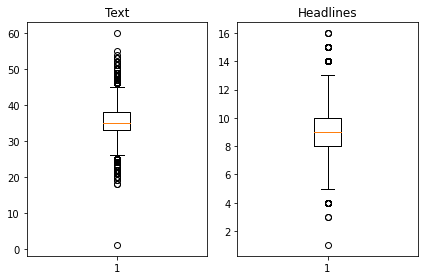

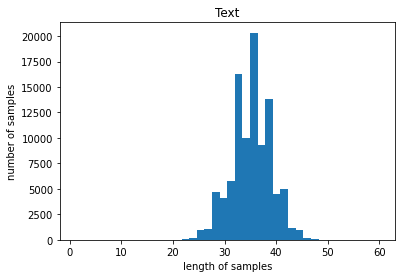

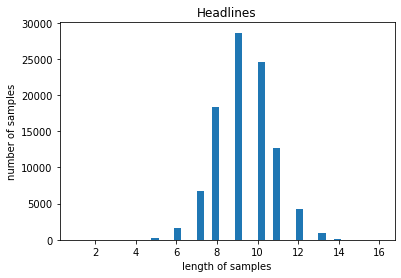

In [17]:
# 샘플 길이 분석
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 50
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
    return sum(1 for s in nested_list if len(s.split()) <= max_len) / len(nested_list)

print('Text 길이 50 이하 비율:', below_threshold_len(text_max_len, data['text']))
print('Headlines 길이 12 이하 비율:', below_threshold_len(headlines_max_len, data['headlines']))

Text 길이 50 이하 비율: 0.9998576657177715
Headlines 길이 12 이하 비율: 0.9880337535583571


In [19]:
# text_max_len과 headlines_max_len보다 긴 샘플 제거
data = data[
    data['text'].apply(lambda x: len(x.split()) <= text_max_len) & 
    data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 전체 샘플 수 출력
print('전체 샘플수 :', len(data))

전체 샘플수 : 97169


In [20]:
# 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

**훈련 데이터와 테스트 데이터 분리**

In [22]:
# 데이터 섞기
indices = np.arange(encoder_input.shape[0]) # [0, 1, 2, 3, ..., N-1] (문장 개수만큼의 인덱스 생성)
np.random.shuffle(indices) # 인덱스를 랜덤하게 섞기

# 데이터를 무작위로 섞되, 각 데이터셋(입력, 출력, 레이블)이 같은 방식으로 섞이도록 유지
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 데이터 분할 (훈련 8:테스트 2)
n_of_val = int(len(encoder_input) * 0.2)
encoder_input_train, encoder_input_test = encoder_input[:-n_of_val], encoder_input[-n_of_val:]
decoder_input_train, decoder_input_test = decoder_input[:-n_of_val], decoder_input[-n_of_val:]
decoder_target_train, decoder_target_test = decoder_target[:-n_of_val], decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


### 정수 인코딩

In [24]:
# 단어 집합 만들기 (각 단어에 고유한 정수 맵핑)
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
# 등장 빈도수가 7회 미만인 단어들의 비중 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69170
등장 빈도가 6번 이하인 희귀 단어의 수: 47144
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 22026
단어 집합에서 희귀 단어의 비율: 68.1567153390198
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5179199164003494


In [26]:
# 단어 집합의 크기 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[38, 472, 8369, 15929, 1, 2835, 3251, 6743, 2017, 65, 2017, 4, 5792, 11216, 10, 518, 4274, 39, 1112, 2017, 1431, 192, 72, 3217, 1355, 123, 144, 192, 72, 1511, 35, 2926], [6587, 262, 697, 438, 1075, 371, 7636, 1306, 4089, 910, 371, 3252, 441, 7636, 13315, 8508, 7213, 10, 394, 4664, 6066, 910, 6127, 7120, 8509, 889, 2889, 220, 889, 2174, 371, 3787, 4343], [136, 579, 581, 2734, 1323, 1597, 4552, 430, 604, 37, 9386, 344, 605, 5291, 1582, 147, 19301, 248, 7637, 4552, 1, 2734, 3488, 164, 136, 579, 1640, 19, 13736, 517, 1222, 8652]]


In [28]:
# headlines 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
# 등장 빈도수가 6회 미만인 단어들의 비중 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29936
등장 빈도가 5번 이하인 희귀 단어의 수: 19570
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 10366
단어 집합에서 희귀 단어의 비율: 65.37279529663282
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.695442935068975


In [30]:
# 단어 집합의 크기 제한
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 928, 155, 33, 108, 14, 1378, 1749, 2093], [1, 8747, 539, 314, 5818, 3, 1628, 509, 314, 1974, 4227], [1, 347, 970, 349, 770, 1484, 468, 20, 9491, 1588], [1, 7648, 2651, 181, 32, 1003, 15, 5819, 966], [1, 300, 426, 5, 852, 47, 37, 2652, 1689, 15, 1690]]
target
decoder  [[928, 155, 33, 108, 14, 1378, 1749, 2093, 2], [8747, 539, 314, 5818, 3, 1628, 509, 314, 1974, 4227, 2], [347, 970, 349, 770, 1484, 468, 20, 9491, 1588, 2], [7648, 2651, 181, 32, 1003, 15, 5819, 966, 2], [300, 426, 5, 852, 47, 37, 2652, 1689, 15, 1690, 2]]


In [31]:
# 요약문에서 길이가 0이 된 샘플 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77735
훈련 레이블의 개수 : 77735
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [32]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계하기

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [34]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [35]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

In [36]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [37]:
# 설계한 모델로 훈련 진행
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 38s 101ms/step - loss: 5.6166 - val_loss: 5.1829
Epoch 2/50
304/304 [==============================] - 30s 100ms/step - loss: 5.0445 - val_loss: 4.8291
Epoch 3/50
304/304 [==============================] - 31s 103ms/step - loss: 4.7198 - val_loss: 4.5655
Epoch 4/50
304/304 [==============================] - 32s 106ms/step - loss: 4.4501 - val_loss: 4.3782
Epoch 5/50
304/304 [==============================] - 33s 109ms/step - loss: 4.2372 - val_loss: 4.2237
Epoch 6/50
304/304 [==============================] - 33s 109ms/step - loss: 4.0636 - val_loss: 4.1155
Epoch 7/50
304/304 [==============================] - 33s 109ms/step - loss: 3.9162 - val_loss: 4.0249
Epoch 8/50
304/304 [==============================] - 33s 109ms/step - loss: 3.7873 - val_loss: 3.9566
Epoch 9/50
304/304 [==============================] - 33s 109ms/step - loss: 3.6731 - val_loss: 3.8937
Epoch 10/50
304/304 [==============================] - 33s 109ms/step - l

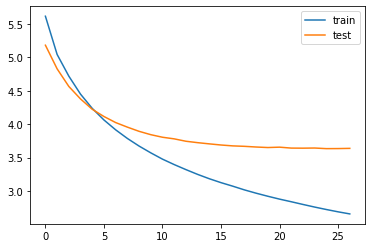

In [38]:
# 훈련과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [39]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
#어텐션 메커니즘을 사용하는 입력층 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [41]:
#어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [42]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()  # 마지막 공백 제거

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [44]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : batsman cheteshwar pujara returned india playing xi lord test england dropped first test run first innings friday pujara joined former england wicketkeeper batsman matt prior run number times tests last years 
실제 요약 : pujara run out joint most times in tests in last years
예측 요약 :  pujara has played test runs in balls in england


원문 : niti aayog ceo amitabh kant denied reports delhi lieutenant governor anil baijal replacing cm arvind kejriwal think tank meeting calling totally incorrect said response kejriwal tweet stating authorised baijal attend meeting behalf comes amidst kejriwal sit protest official residence 
실제 요약 : niti ceo denies kejriwal post on replacing him at meet
예측 요약 :  cannot take action if you cannot take my meeting kejriwal


원문 : carbon dioxide atmosphere mars nearly ideal conditions creating oxygen future manned missions europe based researchers found researchers suggested using low temperature split co oxygen carbon could used mars cold atmosphere would slow 

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [45]:
# 패키지 설치 및 가져오기
import pandas as pd
import urllib.request
from summa.summarizer import summarize

In [46]:
# 뉴스 기사 데이터 다운로드 및 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv",
                           filename="news_summary_more.csv")

data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [47]:
# 랜덤 샘플 선택 (예제: 3번째 기사)
sample_text = data['text'][2]  # 2번째 행의 뉴스 기사 원문

print("\n원문:")
print(sample_text)  # 원문 출력


원문:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [57]:
# 비율 기반 요약 (뉴스 기사 원문의 50% 요약)
print("\n비율 기반 요약 (50%)")
print(summarize(sample_text, ratio=0.5))


비율 기반 요약 (50%)
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [58]:
# 단어 수 기반 요약 (단어 30개만 유지)
print("\n단어 수 기반 요약 (30단어)")
print(summarize(sample_text, words=30))


단어 수 기반 요약 (30단어)
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series.
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [59]:
# 요약 결과를 리스트 형태로 출력
print("\n리스트 형태 요약")
print(summarize(sample_text, ratio=0.5, split=True))


리스트 형태 요약
['The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.']


In [64]:
# 원문, 추출적 요약 비교
for i in range(70, 80):  # 70번부터 79번까지 총 10개의 샘플 요약
    original_text = data['text'][i]  # 원문 가져오기

    # 단어 수 기반 요약 (20단어 유지)
    extractive_summary = summarize(original_text, words=20)

    print(f"\n\n===== 샘플 {i} =====")
    print(f"원문:\n{original_text}\n")
    print(f"추출적 요약(20단어 유지):\n{extractive_summary}\n")



===== 샘플 70 =====
원문:
Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, in hopes of increasing sales, are reportedly occurring for second time in 12 years.

추출적 요약(20단어 유지):
"WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.



===== 샘플 71 =====
원문:
Scientists in Australia's Flinders University are testing a wetsuit prototype that could protect its wearer after a shark attack. The suit, made of synthetic material similar to the material used in bulletproof vests, could help reduce blood loss after a shark attack. "The majority of fatalities from shark bites is due to blood loss...shock from blood loss," a scientist said.

추출적 요약(20단어 유지):
"The majority of fatalities from shark bites is due t